# Dynamic Bandwidth Trace Handler based on FCC-Trace
## Preprocssing FCC Trace 
### T1 : Generate ftrace.csv 
* 목적 : 조건을 만족하는 사용자 단말을 식별하고 해당 단말의 전송률 평균과 표준편차를 구한다.
* Output - frace.csv : CSV Fields = [ unit_id, count, avg_bw, std_bw ]
    - unit_id : 추출된 사용자 단말의 ID
    - count : 해당 단말의 trace sample의 수
    - avg_bw : 해당 단말의 전송률 평균
    - std_bw : 해당 단말의 전송률 표준 편차
* Input 
    - csv_path : FCC 원본 Trace --> curr_webget.csv의 경로명
    - target_url : 특정 목적지에 대한 Trace Sample만 추출
        + bbc.com, bing.com, apple.com, cnn.com, ebay.com, msn.com, goolge.com, imdb.com 등이 있음
        + 정보량이 많은 target을 대상으로 하는 것이 적합(?)
        + default = 'http://edition.cnn.com/' 
    - nmin_sample : Sample 수가 충분히 많은 단말만 추출하기 위한 Sample수 추출 하한
        + default = 100
* 동작 개요
    - target_url을 목적지로 하고 Sample 수가 nmin_sample 이상인 unit_id의 sample을 추출하고
    - 해당 unit_id의 전송률 평균과 표준편차를 구한 후 csv file로 저장
* 사용법
    - 아래 Code Cell을 실행 
    - 시간이 많이 소요. target_url을 변경하지 않는 한 재수행 필요 없음. 생성된 ftrace.csv 반복 사용 

In [1]:
import numpy as np
import pandas as pd 
from itertools import chain
def parse_fcc_trace(csv_path, target_url, nmin_samples) :
    n_count=0
    use_col = ['unit_id','dtime', 'target', 'fetch_time', 'bytes_total', 'bytes_sec']
    freader = pd.read_csv(csv_path, chunksize=10000, usecols=use_col)
    f_trace = pd.DataFrame()
    use_col.remove('target')
    #max_id = 0  # max('unit_id') = 47073261, # of records = 1294 * 10000

    for dfchunk in freader :
        #f_dfchunk = dfchunk[dfchunk['target']=='http://m.imdb.com/help/']
        f_dfchunk = dfchunk[dfchunk['target']==target_url]
        f_trace = f_trace.append(f_dfchunk[use_col], ignore_index=True)
        n_count += 1
        if n_count > 2000 :         # of records = 1294 * 10000
            break

    xdf = f_trace.groupby(['unit_id']).count()['dtime'].to_frame('count')
    xdf['avg_bw'] = f_trace.groupby(['unit_id']).mean()['bytes_sec'] * 8 / 1000000
    xdf['std_bw'] = f_trace.groupby(['unit_id']).std()['bytes_sec'] * 8 / 1000000

    xdf[xdf['count'] >= nmin_samples].to_csv('ftrace.csv')
    #print(n_count * 10000)
    return n_count


# ==================================================
fcc_trace_path = '../fcctrace/curr_webget.csv'
target_url = 'http://edition.cnn.com'
number_of_minimum_samples = 100

parse_fcc_trace(fcc_trace_path, target_url, number_of_minimum_samples)

FileNotFoundError: [Errno 2] No such file or directory: '../fcctrace/curr_webget.csv'

### T2 : Hitogram of Average_Bandwidth - ftrace.csv
* 목적 : 생성한 ftrace.csv를 이용하여 단말들의 평균 전송률 분포를 Histogram으로 확인
    - 최대 전송률, 최소 전송률, 평균 전송률 값도 출력
    - 전체 분포를 확인하기 위한 것이며 동적 대역폭 변화 Trace 생성을 위해 호출할 필요는 없음. 참고용

Max =  29.96327469803921  Min =  0.0  Average =  15.78767897612896


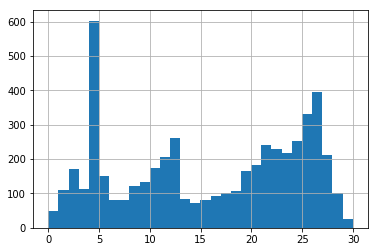

In [5]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

df_tr = pd.read_csv('ftrace.csv')
print('Max = ', df_tr['avg_bw'].max(), ' Min = ', df_tr['avg_bw'].min(), ' Average = ', df_tr['avg_bw'].mean())
hist = df_tr['avg_bw'].hist(bins=30)
plt.show()

## Generating Dynamic Bandwidth Traces
### T1 : choose_IDs 
* 목적 : 동적인 대역폭 변화 Trace를 생성을 위한 단말 식별자 추출
* Output - unit_id list [ minimum, maximum, median ]
    - minimum : 전송률 표준 편차가 가장 작은 단말의 ID (전송률 변화가 가장 적은 단말) 
    - maximum : 전송률 표준 편차가 가장 큰 단말의 ID (전송률 변화가 가장 큰 단말) 
    - median : 전송률 표준 편차가 중간인 ID (전송률 변화가 중간 수준인 단말) 
* Input 
    - target_bw : 평균 전송률 목표치 ex) 5, 10, ... 단위는 Mbps
    - offset : 평균 전송률 목표치에 대한 오차 허용치
        + 즉 평균 전송률이 [target_bw - offset, target_bw + offset ]인 단말들을 추출함
    - fdebug : True이면 부가 정보를 추출, 대상 단말들의 전송률 변화 분포 등을 확인할 수 있음
* 동작 개요
    - ftrace.csv에서 평균 전송률이 [target_bw - offset, target_bw + offset ] 사이의 값을 가지는 단말들을 추출함
    - 추출한 단말들을 전송률 변화수준, 즉 표준 편차 값을 기준으로 정렬하고
    - 전송률 변화 수준이 가장 작은 단말, 가장 큰 단말, 중위 단말의 id를 구해 return 한다
* 사용법
    - 아래 Code Cell을 실행하면 5Mbps (+- 0.1)와 10Mbps (+- 0.5)의 평균 전송률을 가지는 단말들을 추출하고
    - 그 중 전송률 변화 수준에 따라 3개의 단말 ID를 return 한다
    - 동적 대역폭 변화 Trace 생성 과정에 choose_IDs()가 필요하므로 Generate_BW_Trace 이전에 실행하여야 함

[ 5 Mbps, +- 0.1 Mbps]  : Number of Matching IDs =  213
 - Minimum variation =  8887 	STD =  0.20265002517635136
 - Maximum variation =  39876861 	STD =  1.2899583853307401
 - Median variation =  5521 	STD =  0.2882748287581752


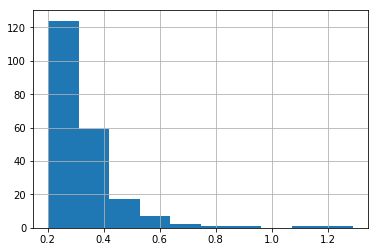

[ 10 Mbps, +- 0.5 Mbps]  : Number of Matching IDs =  161
 - Minimum variation =  3880637 	STD =  0.3721709595207273
 - Maximum variation =  25886677 	STD =  12.283256523972733
 - Median variation =  24734365 	STD =  1.4087205714298263


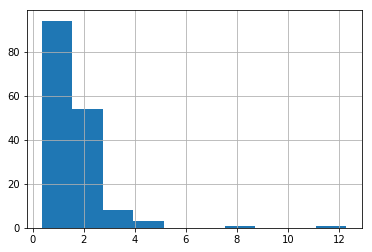

[[8887, 39876861, 5521], [3880637, 25886677, 24734365]]


In [2]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

def choose_IDs(target_bw, offset, fdebug) :
    df_tr = pd.read_csv('ftrace.csv')
    condition = (df_tr.avg_bw > target_bw - offset) & (df_tr.avg_bw < target_bw + offset)
    df_ftr = df_tr[condition].sort_values(by=['std_bw'])
    if fdebug :
        nmatching = len(df_ftr)
        idx_median = (int)(nmatching/2)
        print('[', target_bw, 'Mbps, +-', offset, 'Mbps]', ' : Number of Matching IDs = ', nmatching)
        print(' - Minimum variation = ', df_ftr.iloc[0,0], '\tSTD = ', df_ftr.iloc[0,-1])
        print(' - Maximum variation = ', df_ftr.iloc[-1,0], '\tSTD = ', df_ftr.iloc[-1,-1])
        print(' - Median variation = ', df_ftr.iloc[(int)(len(df_ftr)/2),0], '\tSTD = ', df_ftr.iloc[(int)(len(df_ftr)/2),-1])
        hist2 = df_ftr['std_bw'].hist()
        plt.show()
    IDs = [df_ftr.iloc[0,0],df_ftr.iloc[-1,0], df_ftr.iloc[(int)(len(df_ftr)/2),0]]
    return IDs 

# Example Code =====================
ltarget_bw_offset = [[5, 0.1], [10, 0.5]]

id_array = []
for bw_offset in ltarget_bw_offset :
    id_array.append(choose_IDs(bw_offset[0], bw_offset[1], True))

print(id_array)

### T2 : Generate_BW_Traces 
* 목적 : 동적인 대역폭 변화 Trace를 생성
* Output - 다수의 bwtrace_{bw}Mbps_{[min,max,median]}.csv, CSV Fields = [unit_id,dtime,fetch_time,bytes_total,bytes_sec]
    - unit_id : 동적 대역폭 Trace 생성에 쓰인 사용자 단말의 ID
    - dtime : FCC Trace 원본 파일의 sample time으로 해당 전송률 값이 측정된 시점
    - fetch_time : 대상 서비스 사이트에서 정보를 받아 오는데 걸린 시간, 단위 micro seconds
    - bytes_total : 전송 받은 전체 데이터의 양, 단위 Bytes
    - bytes_sec : 초당 전송 데이터 양, 단위 Bytes per Second
    - File 이름 관련
        + bw - 목표 평균 전송률  
        + [min, max, median] : 목표 평균 전송률 Trace 중 전송률 변화가 최소, 최대, 중위 
* Input 
    - fcc_trace_path : FCC 원본 Trace --> curr_webget.csv의 경로명
    - target_url : 특정 목적지에 대한 Trace Sample만 추출
        + bbc.com, bing.com, apple.com, cnn.com, ebay.com, msn.com, goolge.com, imdb.com 등이 있음
        + 정보량이 많은 target을 대상으로 하는 것이 적합(?)
        + default = 'http://edition.cnn.com/' 
    - ltarget_bw_offset : 동적 Trace를 생성하고자 하는 목표 평균 전송률과 오차 허용치, choose_IDs 참조
* 동작 개요
    - 입력으로 받은 목표 전송률 목록과 choose_IDs()를 이용하여 각 목표 전송률 별 전송률 변화 최소, 최대, 중위인 단말 구하기
    - FCC Trace에서 선택된 단말들의 Trace만 추출
    - 추출된 Trace를 목표 전송률과 전송률 변화를 기준으로 개별 파일로 저장
* 사용법
    - 위의 choose_IDs() Code Cell을 실행하지 않았다면 먼저 실행
    - 아래 Code Cell을 실행
    - 실행 후 파일 생성을 확인

In [3]:
def generate_bw_trace(fcc_trace_path, target_url, ltarget_bw_offset) :
    id_array = []
    for bw_offset in ltarget_bw_offset :
        id_array.append(choose_IDs(bw_offset[0], bw_offset[1], False))
    id_list = [x for sublist in id_array for x in sublist]
    
    use_col = ['unit_id','dtime', 'target', 'fetch_time', 'bytes_total', 'bytes_sec']
    freader = pd.read_csv(fcc_trace_path, chunksize=10000, usecols=use_col) 
    use_col.remove('target')

    f_trace = pd.DataFrame()   
    n_count = 0

    for dfchunk in freader :
        filter_cond = (dfchunk.target == target_url) & dfchunk['unit_id'].isin(id_list)
        f_trace = f_trace.append(dfchunk.loc[filter_cond][use_col], ignore_index = True)
        n_count += 1
        if n_count > 1500 :         # of records = 1294 * 10000
            break

    ldyn_level = ['min', 'max', 'median']
    for bw_idx in range(len(id_array)) :
        for dyn_level in range(3) :   # ['min', 'max', 'median']
            filename = 'bwtrace_' + str(ltarget_bw_offset[bw_idx][0]) + 'Mbps_' + ldyn_level[dyn_level] + '.csv'
            f_trace[f_trace['unit_id'] == id_array[bw_idx][dyn_level]].to_csv(filename, index=False)
    return
    
# ==================================================
fcc_trace_path = '../fcctrace/curr_webget.csv'
target_url = 'http://edition.cnn.com/'
ltarget_bw_offset = [[5, 0.1], [10, 0.5]]

generate_bw_trace(fcc_trace_path, target_url, ltarget_bw_offset)

### T3 : Simplify_for_Simulation
* 목적 : Generate BW Trace에서 생성한 동적인 대역폭 변화 Trace를 NS-3 Simulation Code 작성의 편의를 위해 단순화
* Output - sbwtrace_{bw}Mbps_{[min,max,median]}.csv, CSV Fields = [time,bps]
    - time : 대역폭 변화 시점, 단위 micro seconds
    - bps : 변화 시점 이후 대역폭, 단위 bps
    - 단 column 이름이 CSV File에 포함되지 않도록 하였음
* Input 
    - ltarget_bw_offset : 단순 동적 Trace를 생성하고자 하는 목표 평균 전송률
* 동작 개요
    - 입력으로 받은 목표 전송률 목록으로부터 생성된 BW Trace 파일 읽기
    - NS-3 Simulation Trace 구조에 따라 값을 구하여 저장
* 사용법
    - 아래 Code Cell을 실행
    - 실행 후 파일 생성을 확인

In [21]:
import numpy as np
import pandas as pd

def simplify_for_simulation(ltarget_bw) :
    ldyn_level = ['min', 'max', 'median']
    for target_bw in ltarget_bw :
        for dyn_level in ['min', 'max', 'median'] :
            filename = 'bwtrace_' + str(target_bw) + 'Mbps_' + dyn_level +'.csv'
            df = pd.read_csv(filename, usecols = ['fetch_time','bytes_sec'])
            
            # df['fetch_time'].cumsum(axis=0)[1:].values
            na_time = df['fetch_time'].cumsum(axis=0)[:-1].values
            na_bps = df['bytes_sec'][1:].values * 8
            #na_time = na_time - na_time[0]
            new_df = pd.DataFrame({'time' : df['fetch_time'].cumsum(axis=0)[:-1].values, \
                'bps' : df['bytes_sec'][1:].values * 8})
            new_df.to_csv('s'+filename, index=False, header=False, sep=" ")
    return

# ==================================================
ltarget_bw = [5, 10]
simplify_for_simulation(ltarget_bw)